<a href="https://colab.research.google.com/github/tushar-semwal/fedperf/blob/main/Vineeth/Local_Rounds/qFedAvg/qFederatedAveraging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture output
try:
    from google.colab import drive
    drive.mount('/content/drive')

    import os
    path = '/content/drive/MyDrive/Colab Notebooks/OpenMined/'
    os.makedirs(path, exist_ok=True)
except:
    path = './'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g7HhrE0uUBlAa3zLltFNDIpmWMLm7B003xkMKX5Dx-4TUBSLmosbpE


## Imports

In [3]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary
from sklearn.metrics import f1_score

# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# set manual seed for reproducibility
seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Sun Apr 25 11:28:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load the MNIST Dataset

In [4]:
torch.cuda.set_device('cuda:0')

In [5]:
# create transforms
# We will just convert to tensor and normalize since no special transforms are mentioned in the paper
transforms_mnist = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

mnist_data_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=transforms_mnist)
mnist_data_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=transforms_mnist)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw

Processing...
Done!


In [6]:
classes = np.array(list(mnist_data_train.class_to_idx.values()))
classes_test = np.array(list(mnist_data_test.class_to_idx.values()))
num_classes = len(classes_test)
print("Classes: {} \tType: {}".format(classes, type(classes)))
print("Classes Test: {} \tType: {}".format(classes_test, type(classes)))


Classes: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>
Classes Test: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>


In [7]:
print("Image Shape: {}".format(mnist_data_train.data[0].size()))

Image Shape: torch.Size([28, 28])


## Visualize Data

In [8]:
def imshow(img):
	img = img/2 + 0.5 #unnormalize the image
	plt.imshow(img, cmap='gray') # convert from tensor to image

In [9]:
def visualize(dataset):
  figure = plt.figure(figsize=(25,4))
  for i in range(20):
    axis = figure.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    data = dataset.data[i]
    data = data.numpy()

    target = dataset.targets[i]
    target = target.numpy()
    imshow(data)
    axis.set_title(target)


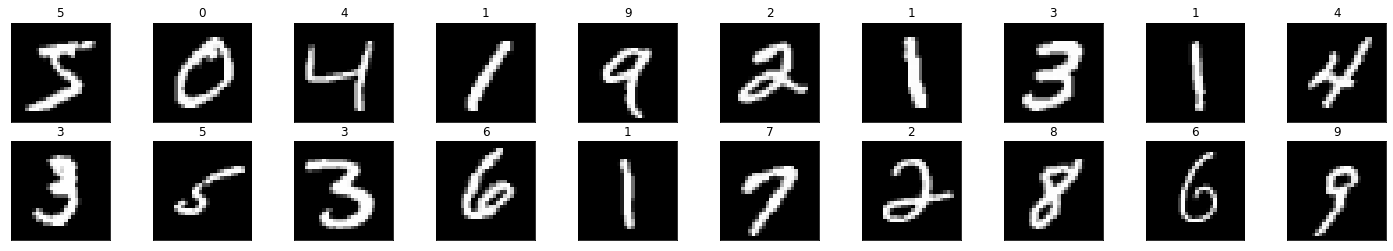

In [10]:
visualize(mnist_data_train)

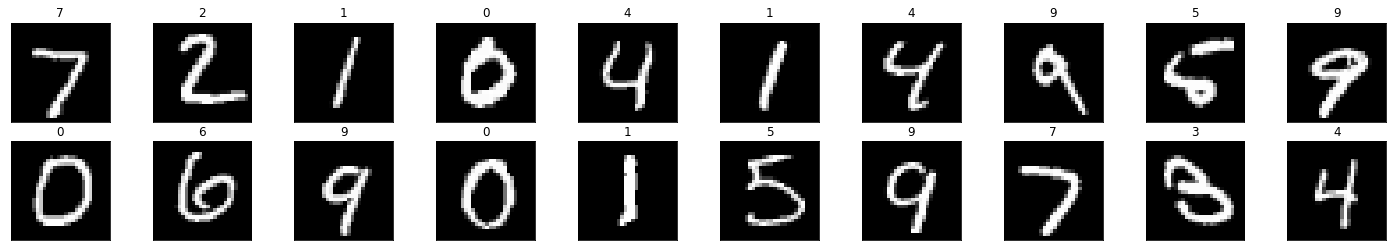

In [11]:
visualize(mnist_data_test)

## Partitioning the Data (IID and non-IID)

In [12]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

In [13]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.targets.numpy()

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict


## Models

In [14]:
class MNIST_2NN(nn.Module):
  """
  A simple multilayer-perceptron with 2-hidden layers with 200 units each
  using ReLu activations

  Total Expected Params: 199,210
  """
  def __init__(self):
    super(MNIST_2NN, self).__init__()

    self.fc1 = nn.Linear(28*28, 200)
    self.fc2 = nn.Linear(200, 200)
    self.fc3 = nn.Linear(200, 10)

  def forward(self, x):
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    out = self.fc3(x)

    return x

In [15]:
class MNIST_CNN(nn.Module):
  """
  CNN with two 5x5 convolution lauers(the first with 32 channels, second with 64,
  each followed with 2x2 max pooling), a fully connected layer with 512 uunits and 
  ReLu activation, and the final Softmax output layer

  Total Expected Params: 1,663,370
  """
  def __init__(self):
    super(MNIST_CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
    
    self.pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(p=0.2)

    self.fc1 = nn.Linear(1024, 512)
    self.out = nn.Linear(512, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.dropout(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.out(x)
    out = F.log_softmax(x, dim=1)

    return out

### Print Model Summaries

In [16]:
mnist_mlp = MNIST_2NN()
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_mlp.cuda()
  mnist_cnn.cuda()

print("MNIST MLP SUMMARY")
print(summary(mnist_mlp, (28,28)))

print("\nMNIST CNN SUMMARY")
print(summary(mnist_cnn, (1, 28,28)))

MNIST MLP SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         157,000
            Linear-2                  [-1, 200]          40,200
            Linear-3                   [-1, 10]           2,010
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.76
Estimated Total Size (MB): 0.77
----------------------------------------------------------------
None

MNIST CNN SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
         MaxPool2d-2           [-1, 32, 12, 12]               0
            Conv2d-3             [-1, 64, 8, 8]          51,264

## q Federated Averaging

### Local Training (Client Update)

Local training for the model on client side

In [17]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      image, label = self.dataset[self.idxs[item]]
      return image, label


class ClientUpdate(object):
  def __init__(self, dataset, batch_size, learning_rate, epochs, idxs, q=None):
    if hasattr(dataset, 'dataloader'):
        self.train_loader = dataset.dataloader(batch_size=batch_size, shuffle=True)
    else:
        self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batch_size, shuffle=True)

    self.learning_rate = learning_rate
    self.epochs = epochs
    self.q = q
    if not self.q:
        # TODO: Client itself adjust fairness 
        pass
    self.mu = 1e-10

  def train(self, model):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)

    e_loss = []

    model_weights = copy.deepcopy(model.state_dict())
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0

      model.train()
      # for data, labels in tqdm(self.train_loader):
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, labels)
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)


    total_loss = sum(e_loss)/len(e_loss)

    # delta weights
    model_weights_new = copy.deepcopy(model.state_dict())
    L = 1.0 / self.learning_rate

    delta_weights, delta, h = {}, {}, {}
    loss_q = np.float_power(total_loss + self.mu, self.q)
    # updating the global weights
    for k in model_weights_new.keys():
      delta_weights[k] = (model_weights[k] - model_weights_new[k]) * L
      delta[k] =  loss_q * delta_weights[k]
      # Estimation of the local Lipchitz constant
      h[k] = (self.q * np.float_power(total_loss + self.mu, self.q - 1) * torch.pow(torch.norm(delta_weights[k]), 2)) + (L * loss_q)

    return delta, h, total_loss

### Server Side Training


In [18]:
def client_sampling(n, m, weights=None, with_replace=False):
    pk = None
    if weights:
        total_weights = np.sum(np.asarray(weights))
        pk = [w * 1.0 / total_weights for w in weights]

    return np.random.choice(range(n), m, replace=with_replace, p=pk)

In [19]:
def training(model, rounds, batch_size, lr, ds, ds_test, data_dict, C, K, E, q, sampling, plt_title, plt_color):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - ds_test:         Dataset used for testing
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - tb_writer_name:  Directory name to save the tensorboard logs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  # train_accuracy = []
  train_loss = []
  test_accuracy = []
  test_loss = []
  f1_macro = []
  f1_weighted = []

  # client weights by total samples
  p_k = None
  if sampling == 'weighted':
    p_k = [len(data_dict[c]) for c in data_dict] if ds else [len(data_dict[c]['train_ds']) for c in data_dict]

  # Time log
  start_time = time.time()

  users_id = list(data_dict.keys())

  for curr_round in range(1, rounds+1):
    deltas, hs, local_loss = [], [], []

    m = max(int(C*K), 1)    
    S_t = client_sampling(K, m, weights=p_k, with_replace=False)

    print('Round: {} Picking {}/{} clients: {}'.format(curr_round, m, K, S_t))

    global_weights = model.state_dict()

    for k in range(len(S_t)):
      key = users_id[k]
      ds_ = ds if ds else data_dict[key]['train_ds']
      idxs = data_dict[key] if ds else None
      local_update = ClientUpdate(dataset=ds_, batch_size=batch_size, learning_rate=lr, epochs=E, idxs=idxs, q=q)
      delta_k, h_k, loss = local_update.train(model=copy.deepcopy(model))

      deltas.append(copy.deepcopy(delta_k))
      hs.append(copy.deepcopy(h_k))
      local_loss.append(copy.deepcopy(loss))

    # Perform qFedAvg
    h_sum = copy.deepcopy(hs[0])
    delta_sum = copy.deepcopy(deltas[0])
    
    for k in h_sum.keys():
        for i in range(1, len(hs)):
            h_sum[k] += hs[i][k]
            delta_sum[k] += deltas[i][k]

    new_weights = {}
    for k in delta_sum.keys():
        for i in range(len(deltas)):
            new_weights[k] = delta_sum[k] / h_sum[k]

    # Updating global model weights
    for k in global_weights.keys():
        global_weights[k] -= new_weights[k]

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    train_loss.append(loss_avg)

    # test
    test_criterion = nn.CrossEntropyLoss()
    test_accuracy_current, test_loss_current, f1_macro_current, f1_weighted_current =  testing(copy.deepcopy(model), ds_test, 128, test_criterion, num_classes, classes_test)
    test_accuracy.append(test_accuracy_current)
    test_loss.append(test_loss_current)
    f1_macro.append(f1_macro_current)
    f1_weighted.append(f1_weighted_current)

  end_time = time.time()
  
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Train_loss.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(test_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Test Loss',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Test_loss.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(test_accuracy)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Test Accuracy',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Test_Accuracy.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(f1_macro)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='F1 Macro',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_F1_Marco.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(f1_weighted)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='F1 Weighted',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_F1_Weighted.jpg', format='jpg')
  plt.show()

  print("Training Done!")
  print("Total time taken to Train: {}\n\n".format(end_time-start_time))
  
  return model, train_loss, test_accuracy, test_loss, f1_macro, f1_weighted

## Testing Loop

In [20]:
def testing(model, dataset, bs, criterion, num_classes, classes, print_info=False):
  #test loss 
  test_loss = 0.0
  y_true, y_hat = None, None

  correct_class = list(0 for i in range(num_classes))
  total_class = list(0 for i in range(num_classes))

  if hasattr(dataset, 'dataloader'):
    test_loader = dataset.dataloader(batch_size=bs, shuffle=False)
  else:
    test_loader = DataLoader(dataset, batch_size=bs, shuffle=False)

  l = len(test_loader)

  model.eval()
  for i, (data, labels) in enumerate(test_loader):

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, dim=1)

    # For F1Score
    y_true = np.append(y_true, labels.data.view_as(pred).cpu().numpy()) if i != 0 else labels.data.view_as(pred).cpu().numpy()
    y_hat = np.append(y_hat, pred.cpu().numpy()) if i != 0 else pred.cpu().numpy()

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    for i, lbl in enumerate(labels.data):
      try:
        correct_class[lbl.item()] += correct[i]
        total_class[lbl.item()] += 1
      except:
          print('Error', lbl, i)
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  test_accuracy = 100. * np.sum(correct_class) / np.sum(total_class)
  # Avg F1 Score
  f1_macro = f1_score(y_true, y_hat, average='macro')
  # F1-Score -> weigthed to consider class imbalance
  f1_weighted =  f1_score(y_true, y_hat, average='weighted')

  if print_info:
    print("Test Loss: {:.6f}\n".format(test_loss))

    for i in range(10):
      if total_class[i]>0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
              (classes[i], 100 * correct_class[i] / total_class[i],
              np.sum(correct_class[i]), np.sum(total_class[i])))
      else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(
          100. * np.sum(correct_class) / np.sum(total_class),
          np.sum(correct_class), np.sum(total_class)))

    print("F1 Score: {:.6f} (macro) {:.6f} (weighted) %\n".format(f1_macro, f1_weighted))
  
  return test_accuracy, test_loss, f1_macro, f1_weighted

## Logger

In [21]:
log_dict = {}
NUM_REPEAT = 1

## MNIST CNN on IID

### Train


Experiment Run Number:  0
Round: 1 Picking 90/100 clients: [14 67 62 15 39 17  2 22 31 48 71 49 58 53 61 55 92  7 13 44  0 26 96 94
 87 59 35 97 25 79 82 29 45 40 70 73 46 91  3 19 50 36 42 68 11 93 99 65
 84 74 18 28 33 12 76  5 24 64 52  1 23 34  4 32 85 83 77 63  6 88 89 47
  8 56 80 75 37 90 69 98 57 86 81 78 30 38 21 16 66 95]
Round: 1... 	Average Loss: 0.51
Round: 2 Picking 90/100 clients: [ 5 33 18  7 32 29 44 21 82 56  6 40 47 46 28 51 10 45 85 92 55 15 77 52
 83 81 25 76 72 80 78 41 63 97 17 64 19 57  3 23 11 16 61 35 69 59 91 22
 75 93 89  2 36 49 62 42 37 53 39 60 96 66 34 98 94  0 38 95 12 13 74 26
 20 54 67 90  9 88 24 65 84 79 31 43 27 86 68 14 99 70]
Round: 2... 	Average Loss: 0.191
Round: 3 Picking 90/100 clients: [28 25 51 74  7 83 20 60 44 55 52  3 41 29 73 48 90  9 43 34 85 92  0 57
 95  5 75 30 23 81 33 71 19 56 50 39 24 13 18 61 31 87 97 37 47 21 65 93
 49 11 94 89 22 68  4 78 99 14 32 96 12 17 26 59 36 69 42 76 15  6 72 46
 10  8 98 70  1 82 88 54 84  2 80 67 63 3

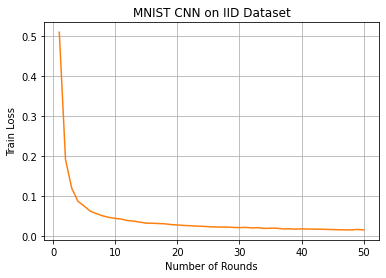

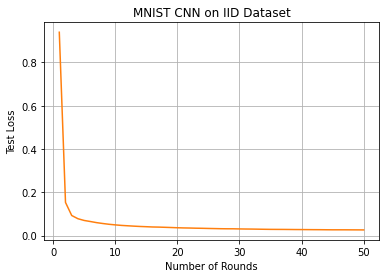

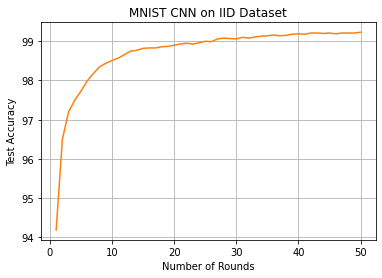

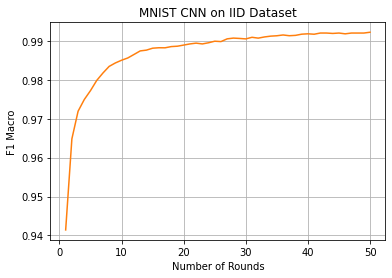

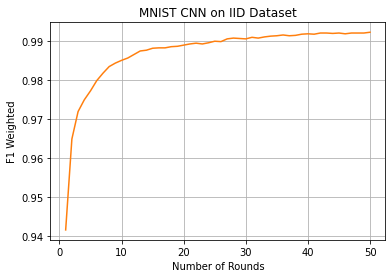

Training Done!
Total time taken to Train: 4880.221732616425




In [22]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT
f1_macro_multiple_runs = [None] * NUM_REPEAT
f1_weighted_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.9
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 5
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # fairness
  q = 0.001
  # sampling
  # sampling = 'uniform'
  sampling = 'weighted'
  # data partition dictionary
  iid_dict = iid_partition(mnist_data_train, 100)
  # load model
  mnist_cnn = MNIST_CNN()

  if torch.cuda.is_available():
    mnist_cnn.cuda()

  mnist_cnn_iid_trained, train_loss, test_accuracy, test_loss, f1_macro, f1_weighted = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, mnist_data_test, iid_dict, C, K, E, q, sampling, "MNIST CNN on IID Dataset", "orange")

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss
  f1_macro_multiple_runs[exp_num] = f1_macro
  f1_weighted_multiple_runs[exp_num] = f1_weighted

### Test

In [23]:
criterion = nn.CrossEntropyLoss()
acc, loss, f1_macro, f1_weighted = testing(mnist_cnn_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test, True)

Test Loss: 0.025864

Test Accuracy of     0: 99% (976/980)
Test Accuracy of     1: 99% (1133/1135)
Test Accuracy of     2: 99% (1028/1032)
Test Accuracy of     3: 99% (1001/1010)
Test Accuracy of     4: 99% (977/982)
Test Accuracy of     5: 99% (884/892)
Test Accuracy of     6: 98% (947/958)
Test Accuracy of     7: 98% (1017/1028)
Test Accuracy of     8: 99% (965/974)
Test Accuracy of     9: 98% (995/1009)

Final Test  Accuracy: 99.230 (9923/10000)
F1 Score: 0.992225 (macro) 0.992299 (weighted) %



In [24]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               'q': q,
               'sampling': sampling
               }

log_dict['MNIST CNN on IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'f1_macro': f1_macro_multiple_runs,
                                'f1_weighted': f1_weighted_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## MNIST CNN on Non IID

### Train


Experiment Run Number:  0
Round: 1 Picking 90/100 clients: [93  1 20 90 89 46 69 30 76 70 99 82 13 85 68 55 36  6 92 66  5 22 12 94
 27 32 61 51 43 65 75  2 60 17 98 84 67 79 56 78 95 19 83 23 80 63 88 21
 86 10 38 28 15 37 71 50 40 72 64 74 48 77 35 42  3 33 96 25 31 26 59 52
  7 24 73 41 29 16 49 11 58  9 14 39 53  0 47 81 62  4]
Round: 1... 	Average Loss: 0.104
Round: 2 Picking 90/100 clients: [57 61  2 64 54 20 47 39 68 78 44 17 29 69 14 18 86  8 88 36 43  9 37 26
 65 85 55 21  1 59 51 25 66 22  5 99  3 81 75 24 50 56 62 38 13 67 42  4
 32 63 84 41 15  7 48 74 72 10 46 52 45 58 73 90 93 19  0 12 11 80 77 76
 82 40 28 95 89 35 27 83 91 71 23 79 33 53 97 60 70 30]
Round: 2... 	Average Loss: 0.078
Round: 3 Picking 90/100 clients: [ 0 36 79 83 55 86  6 37 15 39 90 29 63 24  8 71 21 81  7 74 30 80  9 10
 14 43 28 11 20 72 64 69 47 12 31 96 94 92 82 23 67 26 38 97 66 18 44 56
 60 35 27  5 65 53 91 87 99 93  2 84 32 52 98 70 89 75 17 19 95 25 77 58
 88 34 33 42 48 76 68 78 45 51 62 85 16 

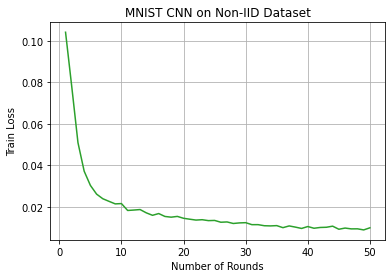

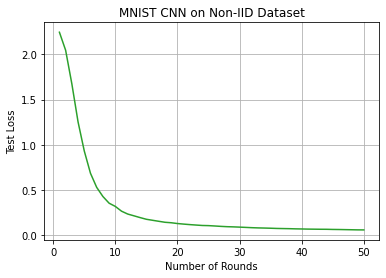

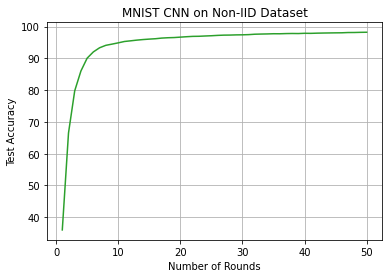

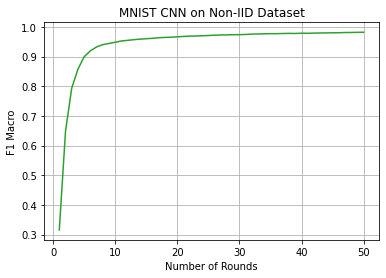

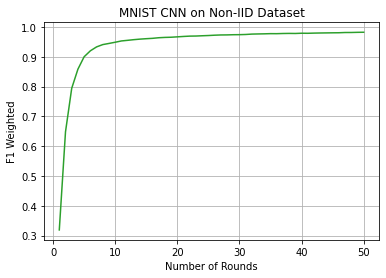

Training Done!
Total time taken to Train: 4892.760519504547




In [25]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT
f1_macro_multiple_runs = [None] * NUM_REPEAT
f1_weighted_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.9
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 5
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # fairness
  q = 0.001
  # sampling
  # sampling = 'uniform'
  sampling = 'weighted'
  # dict containing different type of data partition
  data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
  # load model
  mnist_cnn = MNIST_CNN()

  if torch.cuda.is_available():
    mnist_cnn.cuda()

  mnist_cnn_non_iid_trained, train_loss, test_accuracy, test_loss, f1_macro, f1_weighted = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, mnist_data_test, data_dict, C, K, E, q, sampling, "MNIST CNN on Non-IID Dataset", "green")

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss
  f1_macro_multiple_runs[exp_num] = f1_macro
  f1_weighted_multiple_runs[exp_num] = f1_weighted

### Test

In [26]:
criterion = nn.CrossEntropyLoss()
acc, loss, f1_macro, f1_weighted = testing(mnist_cnn_non_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test, True)

Test Loss: 0.059346

Test Accuracy of     0: 99% (974/980)
Test Accuracy of     1: 99% (1129/1135)
Test Accuracy of     2: 97% (1009/1032)
Test Accuracy of     3: 98% (995/1010)
Test Accuracy of     4: 98% (969/982)
Test Accuracy of     5: 98% (875/892)
Test Accuracy of     6: 98% (946/958)
Test Accuracy of     7: 96% (988/1028)
Test Accuracy of     8: 98% (957/974)
Test Accuracy of     9: 97% (980/1009)

Final Test  Accuracy: 98.220 (9822/10000)
F1 Score: 0.982205 (macro) 0.982181 (weighted) %



In [27]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               'q': q,
               'sampling': sampling
               }

log_dict['MNIST CNN on Non IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'f1_macro': f1_macro_multiple_runs,
                                'f1_weighted': f1_weighted_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## MNIST MLP on IID

### Train

Experiment Run Number:  0
Round: 1 Picking 90/100 clients: [27 63 71 65 68 59 95 41 98 50 76 36 75  4 77  6 81 82 15 91 44 30 97 16
 46 21 35 45 66 78 10 92 58 39 53  7 32 96 79 29 43 87 12  2 56  1 52 33
 85 62 93 47 49 42 83 23 38  0 60 70 54 34 37 28 11 94 17 25 55 51  8 90
 73  9 31 89  3 88 64 48 13 72 40 69 86 74 22 67 61 80]
Round: 1... 	Average Loss: 0.576
Round: 2 Picking 90/100 clients: [53 48 67 60 61 62 43 58 38 83 72 51 29 47 14 73 79 95 98 68 89 40 23 18
 66 25  3 94 26 55 46 49 97  8 42 13 56 78 88 17 35 75 82 87 32  0 91 74
 96 99 24 52 10 65 57 11 93 34 71  5 69 76 84 44  1 30 90 85 54 92 12 19
 31 50  4 63 15 45 22 70 33  7 41 20  6  9 64 37 80  2]
Round: 2... 	Average Loss: 0.218
Round: 3 Picking 90/100 clients: [60 64 42  2 50 38  4 79 39 31 17 70 45 41 11  6 18 98  7 30 57 46 14 43
 94 86 73 49 99 13 90 75 85 19 26 62 12 88 48  9 32 96 81 10 58 54  3  0
 36 47 77 27 97 44 66 93 40 33 74 55 82 92  5 78 65 24 51 61 56 15 76 25
 21 63  8 71 72 53 29 87 84 68 69 52 59 

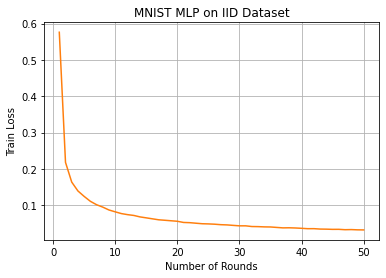

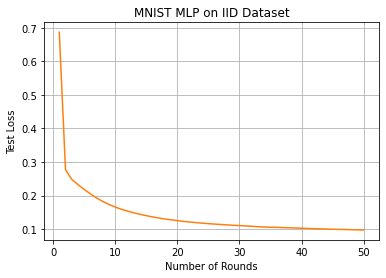

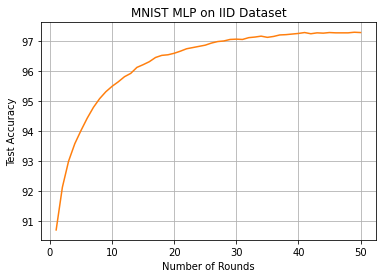

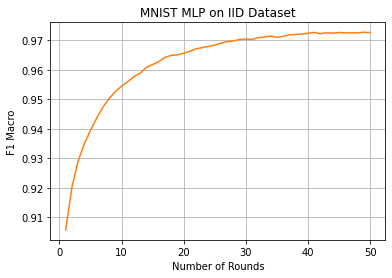

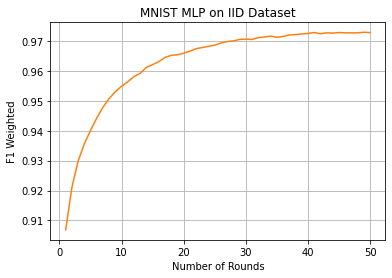

Training Done!
Total time taken to Train: 3232.398926258087




In [28]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT
f1_macro_multiple_runs = [None] * NUM_REPEAT
f1_weighted_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.9
  # number of clients
  K = 100
  # number of training passes on local dataset for each round
  E = 5
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # fairness
  q = 0.001
  # sampling
  # sampling = 'uniform'
  sampling = 'weighted'
  # dict containing different type of data partition
  data_dict = iid_partition(mnist_data_train, 100)
  # load model
  mnist_mlp = MNIST_2NN()

  if torch.cuda.is_available():
    mnist_mlp.cuda()

  mnist_mlp_iid_trained, train_loss, test_accuracy, test_loss, f1_macro, f1_weighted = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, mnist_data_test, data_dict, C, K, E, q, sampling, "MNIST MLP on IID Dataset", "orange")
  
  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss
  f1_macro_multiple_runs[exp_num] = f1_macro
  f1_weighted_multiple_runs[exp_num] = f1_weighted

### Test

In [29]:
criterion = nn.CrossEntropyLoss()
acc, loss, f1_macro, f1_weighted = testing(mnist_mlp_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test, True)

Test Loss: 0.097590

Test Accuracy of     0: 99% (971/980)
Test Accuracy of     1: 98% (1122/1135)
Test Accuracy of     2: 96% (998/1032)
Test Accuracy of     3: 97% (987/1010)
Test Accuracy of     4: 97% (954/982)
Test Accuracy of     5: 96% (861/892)
Test Accuracy of     6: 97% (930/958)
Test Accuracy of     7: 96% (993/1028)
Test Accuracy of     8: 96% (943/974)
Test Accuracy of     9: 96% (969/1009)

Final Test  Accuracy: 97.280 (9728/10000)
F1 Score: 0.972616 (macro) 0.972782 (weighted) %



In [30]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               'q': q,
               'sampling': sampling
               }

log_dict['MNIST MLP on IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'f1_macro': f1_macro_multiple_runs,
                                'f1_weighted': f1_weighted_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## MNIST MLP on Non IID

### Train

Experiment Run Number:  0
Round: 1 Picking 90/100 clients: [ 0 91 89 98 83 94 73 70 82 69  3 77 78 41 46 80 44 51 36 66 23 92  7 43
 30 79 52 12 72 24 35 32 75 58 54 96 20 17  5 84 86  2 34 45 59 47 28 38
 60 37 76 87 39 22 31 26  6 40 81 33 95 42 11 56 63 13 50  4 14 65  8 15
 62 27 71 19 67 68 49 21 90 25 74  1  9 99 48 16 85 61]
Round: 1... 	Average Loss: 0.119
Round: 2 Picking 90/100 clients: [52 10 17 83 92 75 51  0 97  5 47 55 44 96 60 21 81 78 73 12 64 61 42  4
 48 89  2 28 18 85 56 41 50 29 24 91 34 40  7 15  1 94 69 53 65 23 84 74
 27 49 22 32 82  6 70 35 54 45 20  3 59 13 87 95 72 19 98  8 86 80 33 67
 25  9 66 99 36 46 68 37 38 62 39 16 93 77 63 71 90 11]
Round: 2... 	Average Loss: 0.073
Round: 3 Picking 90/100 clients: [ 7 63 47 26 32 85 29  1 33 49 31 57 70  9 83 20 15 93 90 55 84 79 12 43
 74 68 54 22 18 81 10 37 82 23 87 89 75 56 73 61 50 28 80 48 58 41 30 62
  6 97 77 71 99 86 38  0 88  3 21 96 27 25  2 94 69 59 13 40 51 95 98 44
 39 65 35 91 34  5 60 46 24 42  8 45  4 

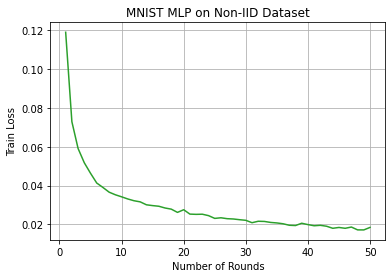

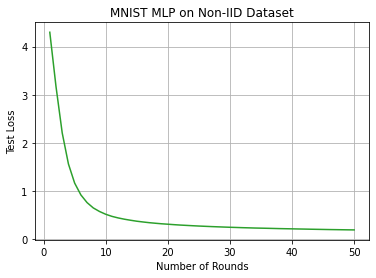

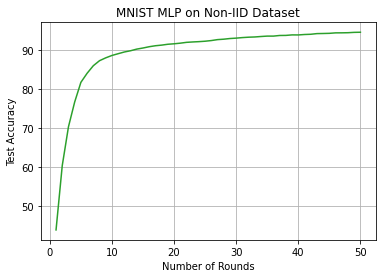

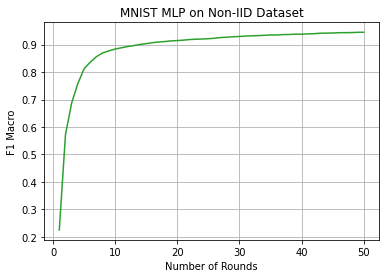

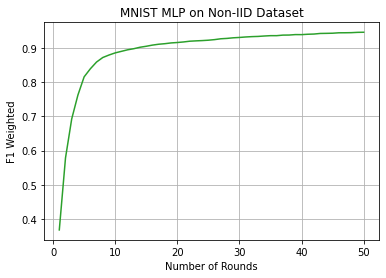

Training Done!
Total time taken to Train: 3171.057588338852




In [31]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT
f1_macro_multiple_runs = [None] * NUM_REPEAT
f1_weighted_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)
  
  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.9
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 5
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # fairness
  q = 0.001
  # sampling
  # sampling = 'uniform'
  sampling = 'weighted'

  # dict containing different type of data partition
  data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
  # load model
  mnist_mlp = MNIST_2NN()

  if torch.cuda.is_available():
    mnist_mlp.cuda()

  mnist_mlp_non_iid_trained, train_loss, test_accuracy, test_loss, f1_macro, f1_weighted = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, mnist_data_test, data_dict, C, K, E, q, sampling, "MNIST MLP on Non-IID Dataset", "green")

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss
  f1_macro_multiple_runs[exp_num] = f1_macro
  f1_weighted_multiple_runs[exp_num] = f1_weighted

### Test

In [32]:
criterion = nn.CrossEntropyLoss()
acc, loss, f1_macro, f1_weighted = testing(mnist_mlp_non_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test, True)

Test Loss: 0.192936

Test Accuracy of     0: 98% (967/980)
Test Accuracy of     1: 98% (1114/1135)
Test Accuracy of     2: 92% (958/1032)
Test Accuracy of     3: 95% (965/1010)
Test Accuracy of     4: 95% (942/982)
Test Accuracy of     5: 92% (826/892)
Test Accuracy of     6: 96% (921/958)
Test Accuracy of     7: 94% (971/1028)
Test Accuracy of     8: 90% (885/974)
Test Accuracy of     9: 89% (905/1009)

Final Test  Accuracy: 94.540 (9454/10000)
F1 Score: 0.944797 (macro) 0.945245 (weighted) %



In [33]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               'q': q,
               'sampling': sampling
               }

log_dict['MNIST MLP on Non IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'f1_macro': f1_macro_multiple_runs,
                                'f1_weighted': f1_weighted_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## Pickle Log

In [34]:
import pickle
 
with open(path + 'qFedAvg_0.9.pkl', 'wb') as file:
  pickle.dump(log_dict, file)

In [35]:
log_dict

{'MNIST CNN on IID': {'f1_macro': [[0.9414268518223489,
    0.9648253096084728,
    0.9719304617677954,
    0.974943468837537,
    0.9772336571336728,
    0.9798382447747074,
    0.9817468249146982,
    0.9834477125871498,
    0.9843343082245399,
    0.9850321959285759,
    0.9856143564479387,
    0.9865139319707348,
    0.9874280693772317,
    0.9876297090767553,
    0.9881249196721145,
    0.9882401480190648,
    0.9882270600428521,
    0.9885386328552468,
    0.9886396373830054,
    0.9889275513417347,
    0.9892234145002183,
    0.9894262049649036,
    0.9892242891401823,
    0.9895199465986565,
    0.9899221112491899,
    0.9898263902416069,
    0.9905281886086283,
    0.9907200786896425,
    0.9906332733468105,
    0.9905159236260269,
    0.9909271661575009,
    0.9907128228754345,
    0.9910153105902779,
    0.991223034396787,
    0.9913206518446435,
    0.9915240203449154,
    0.9913325829561852,
    0.9914217163085078,
    0.991728043815896,
    0.9918241704218662,
    0.99171

In [36]:
import pickle

with open(path + 'qFedAvg_0.9.pkl', 'rb') as file:
  log_dict = pickle.load(file)

In [37]:
print([test_acc[-1] for test_acc in log_dict['MNIST CNN on IID']['test_accuracy']])

[99.23]


In [38]:
print([test_acc[-1] for test_acc in log_dict['MNIST CNN on Non IID']['test_accuracy']])

[98.22]


In [39]:
print([test_acc[-1] for test_acc in log_dict['MNIST MLP on IID']['test_accuracy']])

[97.28]


In [40]:
print([test_acc[-1] for test_acc in log_dict['MNIST MLP on Non IID']['test_accuracy']])

[94.54]


In [41]:
output.show()

Mounted at /content/drive


In [42]:
while True:pass

KeyboardInterrupt: ignored